# 1. Importing the Dependencies and Data

In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
df = pd.read_csv('anomaly_detection.csv')
df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


# 2. Data Splitting

In [4]:
# lets convert the date column to datetime and extract any relevant features
df["date"] = pd.to_datetime(df["date"])
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month
df["Day"] = df["date"].dt.day
df["DayName"] = df["date"].dt.day_name()

In [5]:
df.Year.value_counts()

Year
2020    1098
2024    1098
2021    1095
2022    1095
2023    1095
2025      93
Name: count, dtype: int64

In [6]:
# for now, we will use this range for training. And, will apply EDA to the training set
train = df[df.date <= "2023-12-31"].copy()
train.reset_index(drop=True, inplace=True)

# the test set will be used for the final evaluation
test = df[df.date > "2023-12-31"].copy()
test.reset_index(drop=True, inplace=True)

In [7]:
# just a verification
train.date.min(), train.date.max(), test.date.min(), test.date.max()

(Timestamp('2020-01-01 00:00:00'),
 Timestamp('2023-12-31 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2025-01-31 00:00:00'))

In [8]:
train.shape, test.shape

((4383, 8), (1191, 8))

Since this is a  timeseries dataset, we decided to use data from 2020 to 2023 as train set, and the entirety of 2024 and 2025 as test set. We did not use any holdout validation set as we will utilize cross-validation as we have pretty limited data to use a holdout validation set.

# 3. EDA

In [9]:
train

,date,value,agency,anomaly,Year,Month,Day,DayName
0,2020-01-01,197,AAA,0,2020,1,1,Wednesday
1,2020-01-01,404,CCC,0,2020,1,1,Wednesday
2,2020-01-01,153,BBB,0,2020,1,1,Wednesday
3,2020-01-02,205,AAA,0,2020,1,2,Thursday
4,2020-01-02,401,CCC,0,2020,1,2,Thursday
...,...,...,...,...,...,...,...,...
4378,2023-12-30,274,AAA,0,2023,12,30,Saturday
4379,2023-12-30,145,BBB,0,2023,12,30,Saturday
4380,2023-12-31,266,CCC,1,2023,12,31,Sunday
4381,2023-12-31,162,BBB,1,2023,12,31,Sunday


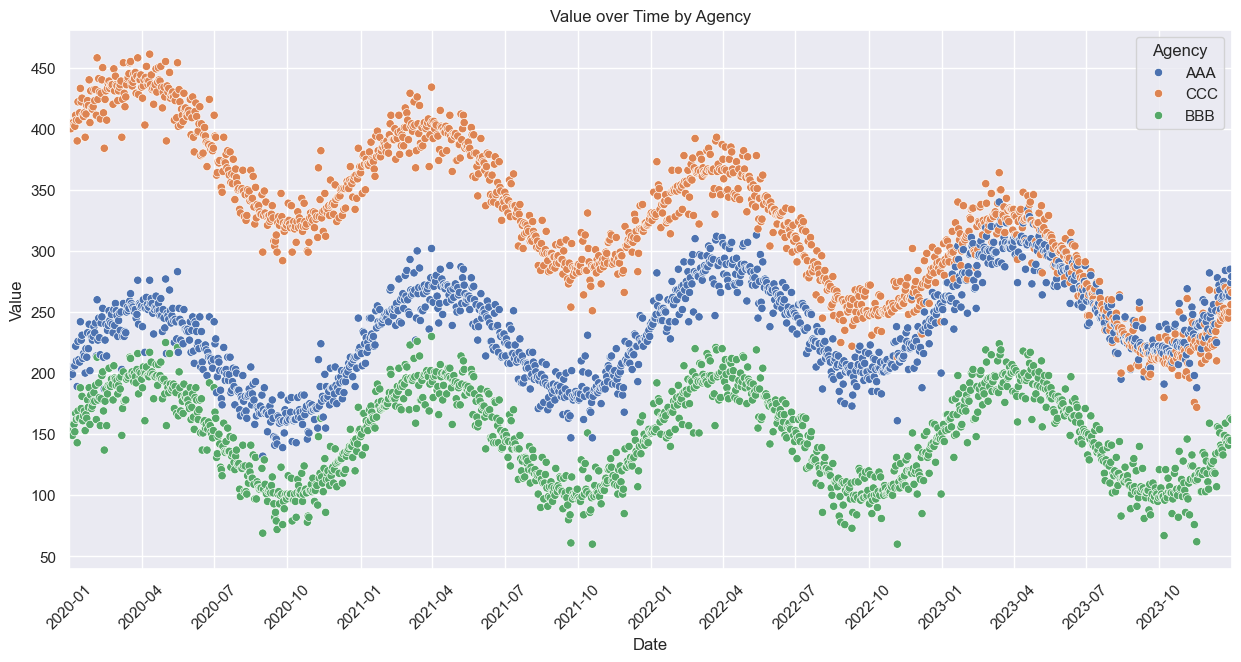

In [10]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=train, x='date', y='value', hue='agency')
plt.title('Value over Time by Agency')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Agency')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-12-31'))
plt.xticks(rotation=45)
plt.show()

If we look here, we can see that the values for each agencies are very much seperable. In fact, besides few data points overlapping between agencies, their pattern is very much seperable as they have a similar pattern with respect to time. The values for each agency seems to be peaking around march/april and lowest are recorded around Sep/Oct every year.

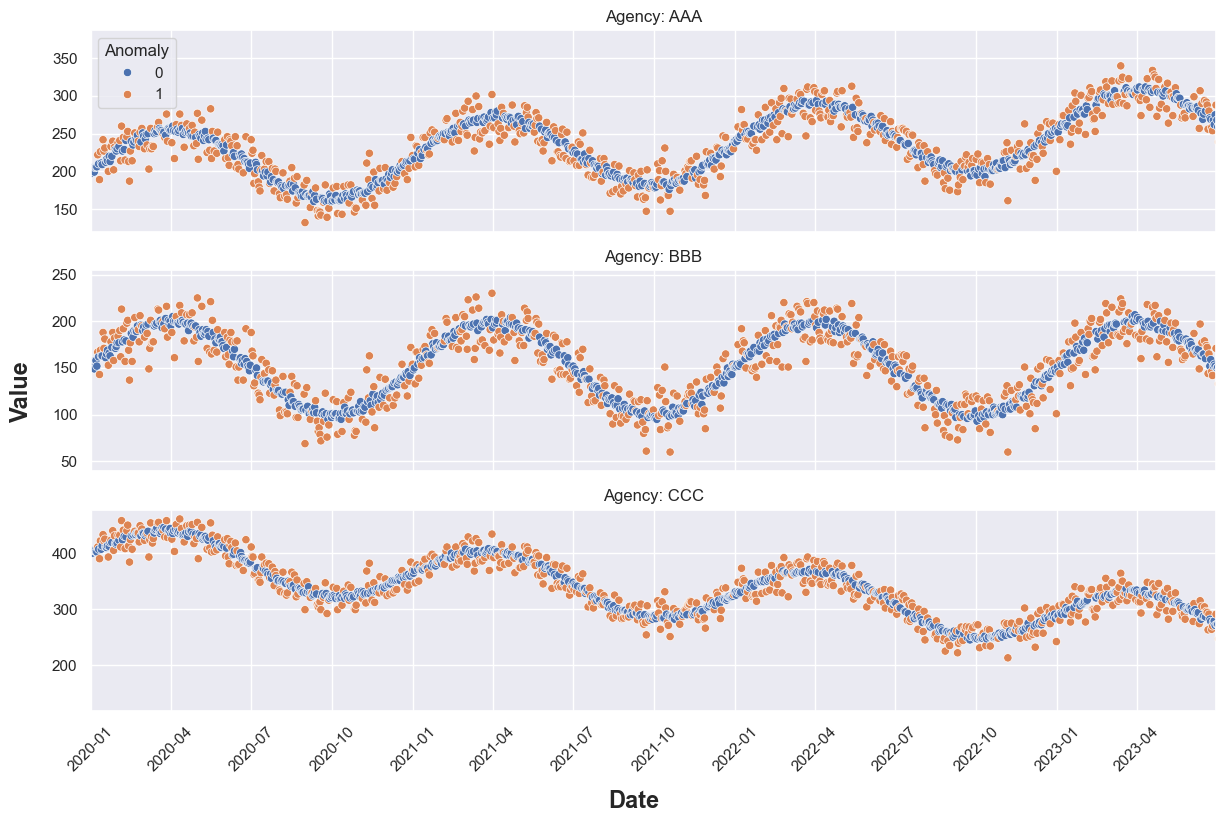

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

agencies = ['AAA', 'BBB', 'CCC']
for i, agency in enumerate(agencies):
    sns.scatterplot(ax=axes[i], data=df[df['agency'] == agency], x='date', y='value', hue='anomaly')
    axes[i].set_title(f'Agency: {agency}')
    axes[i].legend(title='Anomaly')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # we only need one legend
    if i != 0:
        axes[i].get_legend().remove()

    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-06-30'))
    axes[i].tick_params(axis='x', rotation=45)

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=17, fontweight='bold')
fig.text(-0.02, 0.5, 'Value', va='center', rotation='vertical', fontsize=17, fontweight='bold')

plt.tight_layout()
plt.show()

If we look at each of these agencies. the middle values in general seem to be the anomalies and the data points surrounding the anomalies are the non-anomalies. This is a complex non-linear relationship and it is very unlikely a simple logistic regression based classification would yield higher accuracy. Besides, there is the factor of date. The values follow a trend, and we will need to transform date in a way that our model will be able to understand the relationship.

For instance, the value is decreasing for both anomalies and non-anomalies for agency CCC. This pattern needs to be preserved while making predictions on test set which consists of data from 2024/25. Similarly, for agency AAA, the values seem to be gradually increasing whereas, for BBB, it looks constant.

In [12]:
print("Number of anomalies in train data with respect to agency: \n")
print(train.groupby('agency')["anomaly"].value_counts())

Number of anomalies in train data with respect to agency: 

agency  anomaly
AAA     0          793
        1          668
BBB     0          793
        1          668
CCC     0          793
        1          668
Name: count, dtype: int64


It looks like the distribution of samples between anomalies and non-anomalies is pretty balanced. This is good as we won't have to worry about challenges associated with class-imbalance. Generally, you would expect the anomalies to be rare. Here, both are equal.

In [13]:
train

,date,value,agency,anomaly,Year,Month,Day,DayName
0,2020-01-01,197,AAA,0,2020,1,1,Wednesday
1,2020-01-01,404,CCC,0,2020,1,1,Wednesday
2,2020-01-01,153,BBB,0,2020,1,1,Wednesday
3,2020-01-02,205,AAA,0,2020,1,2,Thursday
4,2020-01-02,401,CCC,0,2020,1,2,Thursday
...,...,...,...,...,...,...,...,...
4378,2023-12-30,274,AAA,0,2023,12,30,Saturday
4379,2023-12-30,145,BBB,0,2023,12,30,Saturday
4380,2023-12-31,266,CCC,1,2023,12,31,Sunday
4381,2023-12-31,162,BBB,1,2023,12,31,Sunday


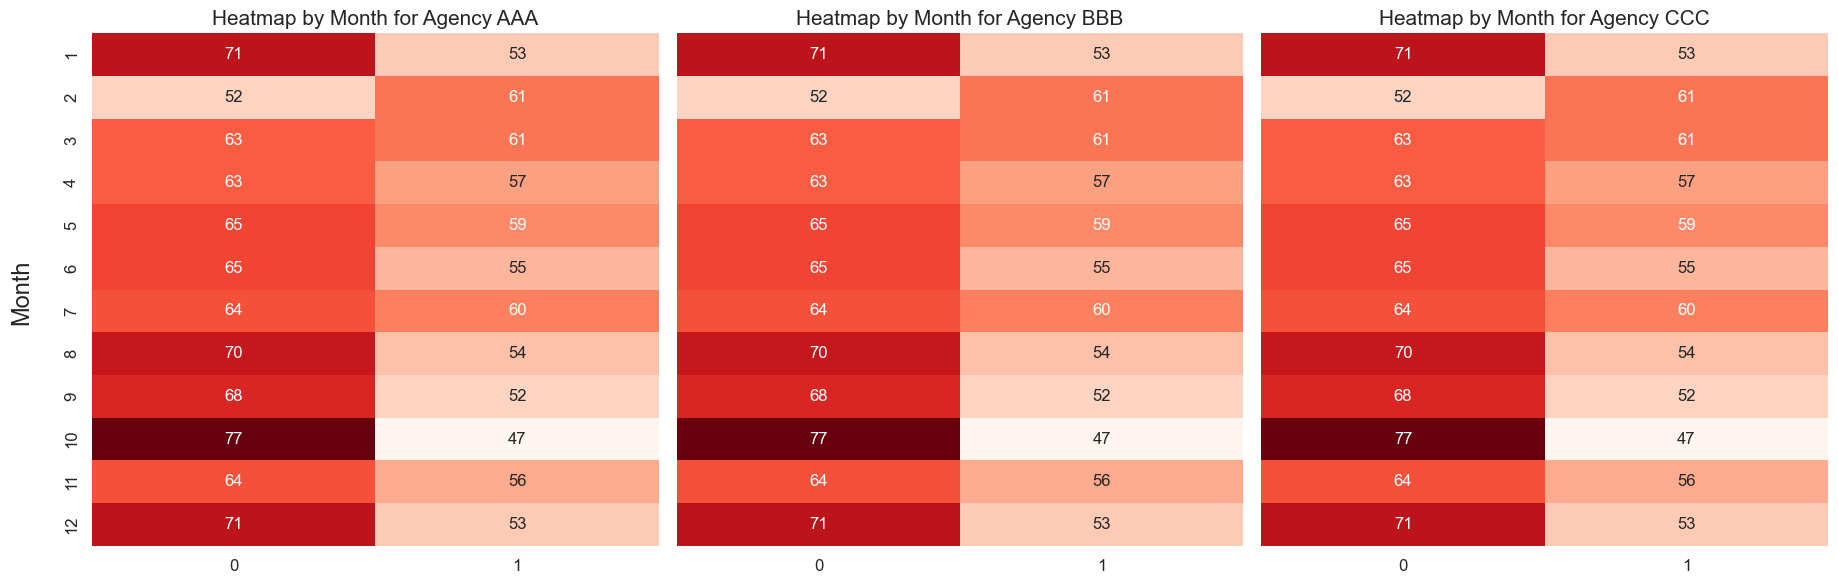

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

agencies = ['AAA', 'BBB', 'CCC']
for i, agency in enumerate(agencies):
    pivot_table = train[train.agency == agency].pivot_table(index='Month', columns='anomaly', values='value', aggfunc='count', fill_value=0)
    
    sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Reds', ax=axes[i], cbar=False)
    axes[i].set_title(f'Heatmap by Month for Agency {agency}', fontsize=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

fig.text(-0.02, 0.5, 'Month', va='center', rotation='vertical', fontsize=17, fontweight='normal')

plt.tight_layout()
plt.show()

Well, looks like the number of anomalies and non-anomalies for each agency for each month is essentially the same. 

In [15]:
print(train.groupby("DayName")["anomaly"].value_counts())

DayName    anomaly
Friday     0          342
           1          285
Monday     0          339
           1          285
Saturday   0          342
           1          285
Sunday     0          327
           1          300
Thursday   0          360
           1          267
Tuesday    0          345
           1          279
Wednesday  0          324
           1          303
Name: count, dtype: int64


This is also not much helpful. It looks like the data is pretty much balanced with respect to the number of samples in each category from every aspect.

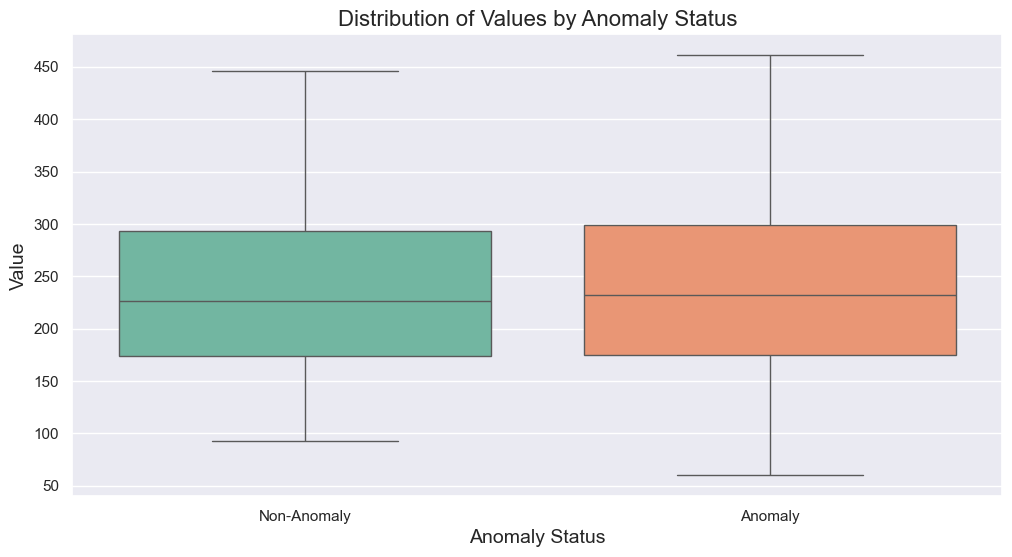

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x="anomaly", y="value", palette="Set2")
plt.title('Distribution of Values by Anomaly Status', fontsize=16)
plt.xlabel('Anomaly Status', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks([0, 1], ['Non-Anomaly', 'Anomaly'])
plt.show()

In general, of course, there is not much difference between the distribution of non-anomaly and anomaly values.

In [17]:
# just keeping backups in case we need to revert back
train_base = train.copy()
test_base = test.copy()

In [18]:
train_base.anomaly.value_counts() / train_base.shape[0] * 100

anomaly
0    54.277892
1    45.722108
Name: count, dtype: float64

In [19]:
test_base.anomaly.value_counts() / test_base.shape[0] * 100

anomaly
0    55.919395
1    44.080605
Name: count, dtype: float64

# 4. Feature Engineering

This step is crucial especially while working with timeseries dataset. It involves tranforming our original data to extract new meaningful features and filter useless ones to improve the performance of our machine learning model. There are mainly two subparts in feature enginnering.

1. Feature Extraction -> It involves applying different sorts of transformations on our data to extract new features that might help the model. We could do EDA with these newly extracted features or apply some technique to determine if extracted feature is relevant or not before training the model. 

2. Feature Selection -> Not all features we have in our data will be relevant. Some might even be noise. It is crucial that we remove useless features through some form of filtration. Finally, after selecting relevant features, we can choose to further transform the features by applying techniques like Standarization, etc.

## 4.1 Feature Extraction

In [20]:
'''
Here, we extract train and test sets for each agency. Since each agency has a value for each day, and they have different patterns,
calculating statistics like rolling average on all 3 agencies at once will probably mix stuff up. So, calculating statistics for each agency 
separately, and them combining them together by using One Hot Encoding makes sure that the temporal pattern of each agency is preserved.
'''

train_AAA = train[train.agency == "AAA"].copy()
test_AAA = test[test.agency == "AAA"].copy()

train_BBB = train[train.agency == "BBB"].copy()
test_BBB = test[test.agency == "BBB"].copy()

train_CCC = train[train.agency == "CCC"].copy()
test_CCC = test[test.agency == "CCC"].copy()

train_AAA = train_AAA[["date", "value", "anomaly", "agency"]]
test_AAA = test_AAA[["date", "value", "anomaly", "agency"]]

train_BBB = train_BBB[["date", "value", "anomaly", "agency"]]
test_BBB = test_BBB[["date", "value", "anomaly", "agency"]]

train_CCC = train_CCC[["date", "value", "anomaly", "agency"]]
test_CCC = test_CCC[["date", "value", "anomaly", "agency"]]

In [21]:
target = "anomaly"
dayname_to_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

In [22]:
def calc_rolling_slope(values: np.array, 
                       window: int) -> tuple[np.array, np.array]:
    '''
    Given a numpy array of values and a rolling window size, use LinearRegression class from scikit-learn to compute slopes and intercepts
    at given rolling window size.

    Parameters:
    values (np.array): A numpy array of values
    window (int): The rolling window size

    Returns:
    tuple[np.array, np.array]: The slopes and intercepts at each rolling window
    '''
    slopes = [np.nan] * window # the first rows (equal to the window size) will have NaN values as we don't have data for 2019
    intercepts = [np.nan] * window

    for i in range(window, len(values)):
        y = values[i-window:i]
        x = np.arange(window).reshape(-1, 1)
        model = LinearRegression().fit(x, y) # fit the model and extract coefficients and intercepts at every rolling intervals
        slopes.append(model.coef_[0])
        intercepts.append(model.intercept_)

    return slopes, intercepts

# Features Extracted:
* ## Date Features
* ## Trigonometric Features
* ## Rolling Window Features (averages, differences, statistical scores over a period of time)

# Most Important Features:
* ## Residuals
* ## Z-score
* ## Relation to the Cosine Function

In [23]:
def apply_transformations(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Given a dataframe, apply transformations to extract temporal features, which include lagged features, cyclical encoding of month and days,
    rolling statistics, rate of change features, rolling z-scores, momentum, exponential moving average, acceleration, residuals, skew and kurtosis.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame

    Returns:
    pd.DataFrame: A enw pandas DataFrame with the extracted features
    '''

    df = df.copy()
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['DayName'] = df['date'].dt.day_name()

    # Cyclical encoding for temporal features (Month, Day and DayName)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['DayName_num'] = df['DayName'].map(dayname_to_num)
    df['DayName_sin'] = np.sin(2 * np.pi * df['DayName_num'] / 7)
    df['DayName_cos'] = np.cos(2 * np.pi * df['DayName_num'] / 7)

    # Lagged features at different intervals
    lags = [1, 2, 3, 4, 5, 6, 7, 14]
    for lag in tqdm(lags):
        df[f'lag_{lag}'] = df['value'].shift(lag)

        # Difference features for all lags
        df[f'diff_{lag}'] = df['value'] - df[f'lag_{lag}']
        
        # Rate of change for all lags
        df[f'roc_{lag}'] = (df['value'] - df[f'lag_{lag}']) / (df[f'lag_{lag}'] + 1e-6)


    # rolling and other stats at weekly and bi-weekly intervals
    windows = [7, 14]
    for window in tqdm(windows):
        df[f'rolling_min_{window}'] = df['value'].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df['value'].rolling(window=window).max()
        df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
        df[f'rolling_range_{window}'] = df[f'rolling_max_{window}'] - df[f'rolling_min_{window}']
        df[f'rolling_momentum_{window}'] = df['value'] - df['value'].shift(window)
        df[f'zscore_{window}'] = (df['value'] - df[f'rolling_mean_{window}']) / (df[f'rolling_std_{window}'] + 1e-6)
        df[f'ema_{window}'] = df['value'].ewm(span=window, adjust=False).mean()

        # calculate short term and long terms slopes as they can help us caputure local trends (first and second order derivatives)
        slope, intercept = calc_rolling_slope(df['value'].values, window)
        df[f'slope_{window}'] = slope
        df[f'intercept_{window}'] = intercept
        df[f'acceleration_{window}'] = df[f'slope_{window}'] - df[f'slope_{window}'].shift(1)

        # adding small valur t prevent division by zero; our dataet doesn't have any zero values, but you never know what  - 
        # - might happen in production
        df[f'relative_to_mean_{window}'] = df['value'] / (df[f'rolling_mean_{window}'] + 1e-6) 
        df[f'relative_to_max_{window}'] = df['value'] / (df[f'rolling_max_{window}'] + 1e-6)
        df[f'relative_to_min_{window}'] = df['value'] / (df[f'rolling_min_{window}'] + 1e-6)

        # skew and kurtosis
        df[f'rolling_skew_{window}'] = df['value'].rolling(7).skew()
        df[f'rolling_kurtosis_{window}'] = df['value'].rolling(7).kurt()
        df[f"residual_{window}"] = df['value'] - df[f'rolling_mean_{window}']

        # Rolling Coefficient of Variation
        df[f'rolling_cv_{window}'] = df[f'rolling_std_{window}'] / (df[f'rolling_mean_{window}'] + 1e-6)


    # we don't need these as they are redundant
    df.drop(columns=['Month', 'Day', 'DayName', 'DayName_num'], inplace=True)
    return df

In [24]:
# applying feature extraction to each agency separately

'''
The reasoning is that each agency has a unique temporal pattern and if we process them together, we risk mixing up the patterns.
That's why we process them seperately and will later combine the dataframes and include one-hot encoded features to identify the agency.
'''
df_transformed_AAA = apply_transformations(pd.concat([train_AAA, test_AAA]))
df_transformed_BBB = apply_transformations(pd.concat([train_BBB, test_BBB]))
df_transformed_CCC = apply_transformations(pd.concat([train_CCC, test_CCC]))

100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


In [25]:
# combining dataframes together
df_transformed = pd.concat([df_transformed_AAA, df_transformed_BBB, df_transformed_CCC], ignore_index=True)
df_transformed.dropna(inplace=True)

In [26]:
# one hot encoding and extracting new features that indicate which agency a row belongs to
df_transformed["agency_AAA"] = np.where(df_transformed["agency"] == "AAA", 1, 0)
df_transformed["agency_BBB"] = np.where(df_transformed["agency"] == "BBB", 1, 0)
df_transformed["agency_CCC"] = np.where(df_transformed["agency"] == "CCC", 1, 0)

In [27]:
#  this is going to be our training dataframe
train = df_transformed[df_transformed.date <= "2023-12-31"].copy()
train.reset_index(drop=True, inplace=True)
train.drop(columns=['date', "value", "agency"], inplace=True)


# this is our test dataframe which will be absolutely untouched until the final evaluation
test = df_transformed[df_transformed.date > "2023-12-31"].copy()
test.reset_index(drop=True, inplace=True)
test.drop(columns=['date', "value", "agency"], inplace=True)

In [28]:
train.head()

,anomaly,Year,Month_sin,Month_cos,Day_sin,Day_cos,DayName_sin,DayName_cos,lag_1,diff_1,...,relative_to_mean_14,relative_to_max_14,relative_to_min_14,rolling_skew_14,rolling_kurtosis_14,residual_14,rolling_cv_14,agency_AAA,agency_BBB,agency_CCC
0,1,2020,0.5,0.866025,-0.101168,-0.994869,0.433884,-0.900969,242.0,-15.0,...,1.074738,0.938017,1.201058,-0.092387,0.282846,15.785714,0.064842,1,0,0
1,1,2020,0.5,0.866025,-0.299363,-0.954139,-0.433884,-0.900969,227.0,4.0,...,1.084143,0.954545,1.222222,-0.661731,0.237699,17.928571,0.068173,1,0,0
2,0,2020,0.5,0.866025,-0.485302,-0.874347,-0.974928,-0.222521,231.0,-19.0,...,0.990985,0.876033,1.121693,0.353596,-1.088365,-1.928571,0.065634,1,0,0
3,0,2020,0.5,0.866025,-0.651372,-0.758758,-0.781831,0.623490,212.0,4.0,...,1.003984,0.892562,1.142857,0.789674,-0.709014,0.857143,0.062143,1,0,0
4,0,2020,0.5,0.866025,-0.790776,-0.612106,0.000000,1.000000,216.0,-2.0,...,0.991725,0.884298,1.132275,0.803735,-0.546199,-1.785714,0.060510,1,0,0


<b> If we look at the above dataframe, we see 71 columns. It is not possible to see the relationship between these columns and the target for all columns. That's why we decided to apply RandomForest + Recursive Feature Elimination technique for feature selection.

## 4.2 Feature Selection

In this step, we utilize a vanilla Random Forest Classifier coupled with Recursive Feature Elimination. It works in the following way.

1. Train RF on all features
2. Remove the least important feature
3. Use calculated feature importances and remove the last one (the least important one)
4. Retrain and repeat from 3 until we get desired number of top-k relevant features.


While it might not be the best method, it is fairly quick and gives us pretty relevant features to work with. Given that we might have 100s of features (if we decide to extract more rolling features based on larger window size), RF-RFE method comes in handy.

In [29]:
# creating training feature matrix and response vector
X_train = train.drop(columns=[target])
y_train = train[target]

In [30]:
%%time

vanilla_RF = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector = RFE(vanilla_RF, n_features_to_select=15) 
selector = selector.fit(X_train, y_train)

CPU times: total: 25.2 s
Wall time: 25.7 s


In [31]:
most_important_features = list(X_train.columns[selector.support_])

In [32]:
most_important_features

['Month_cos',
 'diff_1',
 'diff_2',
 'roc_3',
 'diff_4',
 'diff_7',
 'zscore_7',
 'relative_to_mean_7',
 'residual_7',
 'zscore_14',
 'relative_to_mean_14',
 'relative_to_max_14',
 'rolling_skew_14',
 'rolling_kurtosis_14',
 'residual_14']

So, these are our top 15 most important features. We will go ahead with concatenating one-hot encoded agency features to this list to provide any additional leverage to the model. We do this because, based on our first plot, there is a distinct temporal pattern between the agencies and we don't want to break this on our data.

In [33]:
'''
Finally, adding agency info to the features as we may wanna know which agency a row belongs to.
'''
most_important_features.append("agency_AAA")
most_important_features.append("agency_BBB")
most_important_features.append("agency_CCC")

In [34]:
most_important_features

['Month_cos',
 'diff_1',
 'diff_2',
 'roc_3',
 'diff_4',
 'diff_7',
 'zscore_7',
 'relative_to_mean_7',
 'residual_7',
 'zscore_14',
 'relative_to_mean_14',
 'relative_to_max_14',
 'rolling_skew_14',
 'rolling_kurtosis_14',
 'residual_14',
 'agency_AAA',
 'agency_BBB',
 'agency_CCC']

# 5. Model Training

In [35]:
# preparing the final training and test sets (feature matrices and response vectors)
X_train = train[most_important_features]
y_train = train[target]

X_test = test[most_important_features]
y_test = test[target]

Since this is a timeseries data, we cannot directly use standard cross-validation. This is because we are working with timeseries data. If we do random shuffling, we will introduce data leakage. For instance, we have data from 2020 to 2025. If we used K-fold cross validation, we might see years 2020, 2022 and 2025 in training set and 2022 and 2024 in validation set. This would not only break temporal pattern in the dataset (which is exactly what we are hoping to capture) but it would also lead to data leakage where rows from 2022 will see information from future rows. Therefore, for timeseries datasets, the split should be done in following pattern: 2021-2024 for training, and 2025 for testing. We can use <B>TimeSeriesSplit</b> class from Scikit-Learn to achieve this.

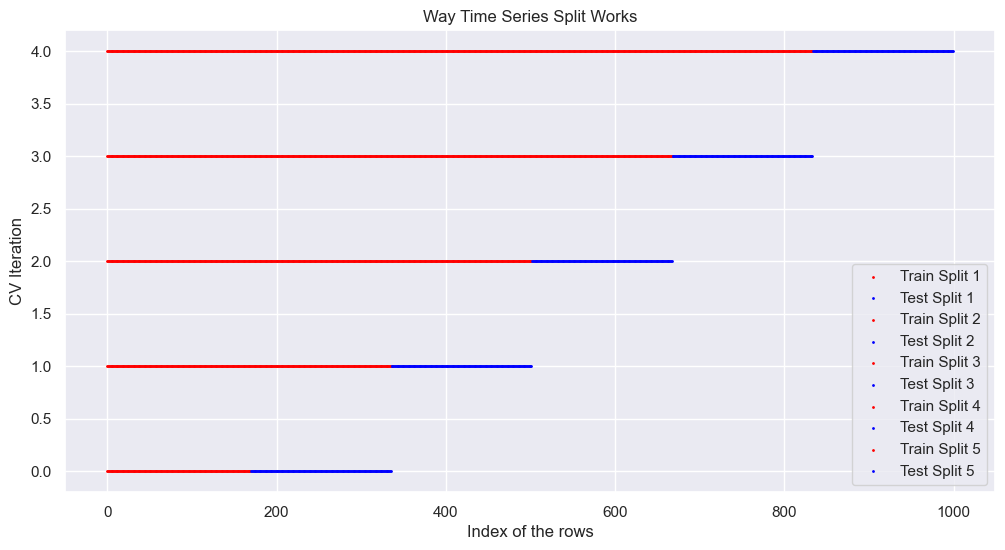

In [36]:
# lets say we have 1000 rows of ordered temporal data
n_samples = 1000  
timeseries_cv = TimeSeriesSplit(n_splits=5)

plt.figure(figsize=(12, 6))
for i, (train_idx, test_idx) in enumerate(timeseries_cv.split(np.arange(n_samples))):
    plt.scatter(train_idx, [i] * len(train_idx), label=f"Train Split {i+1}", color="red", s=1)
    plt.scatter(test_idx, [i] * len(test_idx), label=f"Test Split {i+1}", color="blue", s=1)
plt.xlabel("Index of the rows")
plt.ylabel("CV Iteration")
plt.legend(loc="best")
plt.title("Way Time Series Split Works")
plt.show()

In [37]:
X_train

,Month_cos,diff_1,diff_2,roc_3,diff_4,diff_7,zscore_7,relative_to_mean_7,residual_7,zscore_14,relative_to_mean_14,relative_to_max_14,rolling_skew_14,rolling_kurtosis_14,residual_14,agency_AAA,agency_BBB,agency_CCC
0,0.866025,-15.0,18.0,0.075829,1.0,5.0,0.629993,1.049538,10.714286,1.152623,1.074738,0.938017,-0.092387,0.282846,15.785714,1,0,0
1,0.866025,4.0,-11.0,0.105263,20.0,21.0,0.667225,1.053420,11.714286,1.234270,1.084143,0.954545,-0.661731,0.237699,17.928571,1,0,0
2,0.866025,-19.0,-15.0,-0.123967,3.0,23.0,-0.858533,0.952503,-10.571429,-0.137353,0.990985,0.876033,0.353596,-1.088365,-1.928571,1,0,0
3,0.866025,4.0,-15.0,-0.048458,-26.0,-10.0,-0.413784,0.976744,-5.142857,0.064111,1.003984,0.892562,0.789674,-0.709014,0.857143,1,0,0
4,0.866025,-2.0,2.0,-0.073593,-13.0,3.0,-0.627435,0.965828,-7.571429,-0.136761,0.991725,0.884298,0.803735,-0.546199,-1.785714,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333,1.000000,-5.0,0.0,-0.020000,-25.0,0.0,-0.762442,0.973878,-6.571429,-0.573346,0.983090,0.907407,2.055631,4.684098,-4.214286,0,0,1
4334,1.000000,5.0,0.0,0.020408,0.0,-3.0,-0.132726,0.995449,-1.142857,0.010420,1.000286,0.925926,2.268336,5.584725,0.071429,0,0,1
4335,1.000000,19.0,24.0,0.076000,24.0,21.0,1.384576,1.058460,14.857143,2.171830,1.072629,0.996296,1.043387,-0.936414,18.214286,0,0,1
4336,1.000000,-13.0,6.0,0.044898,6.0,-14.0,0.463865,1.015297,3.857143,0.563293,1.019050,0.948148,1.659558,3.018185,4.785714,0,0,1


In [38]:
def optimize_model(model_pipeline: Pipeline, 
                   X_train: pd.DataFrame, 
                   y_train: pd.DataFrame, 
                   param_space: dict, 
                   n_iter: int, 
                   cv_splits=5):
    """
    This function takes in model pipeline, training set, hyperparameter space and number of iterations for RandomizedSearchCV.
    It will then optimize the given model based on the provided hyperparameter set and selected scoring metric, and return the best model.
    It does this by randomly selecting a set of hyperparameters from the provided hyperparameter space and evaluating the model.

    Parameters:
    model_pipeline (Pipeline): A scikit-learn Pipeline object
    X_train (pd.DataFrame): The training feature matrix
    y_train (pd.DataFrame): The response vector for training
    param_space (dict): The hyperparameter space to search
    n_iter (int): The number of iterations to search
    cv_splits (int): The number of cross-validation splits

    Returns:
    RandomizedSearchCV: A RandomizedSearchCV object
    Pipeline: The best model found by the RandomizedSearchCV
    """
    # This is our Timeseries Cross Validator. If we had used the regular CV, it would have broken the temporal order -
    # - which could have lead to data leakage.
    timeseries_split = TimeSeriesSplit(n_splits=cv_splits)
        
    random_search = RandomizedSearchCV(
        estimator=model_pipeline,
        param_distributions=param_space,
        n_iter=n_iter,
        scoring='f1', # we choose f1 score
        cv=timeseries_split, 
        random_state=42,
        n_jobs=-1,
        refit=True,
    )
    
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    return random_search, best_model

In [39]:
columns_to_standarize = X_train.columns[:-3] # excluding one-hot encoded agency columns
columns_to_standarize

Index(['Month_cos', 'diff_1', 'diff_2', 'roc_3', 'diff_4', 'diff_7',
       'zscore_7', 'relative_to_mean_7', 'residual_7', 'zscore_14',
       'relative_to_mean_14', 'relative_to_max_14', 'rolling_skew_14',
       'rolling_kurtosis_14', 'residual_14'],
      dtype='object')

Given that most of our selected features are numeric, lets quickly see the correlation between them.

<AxesSubplot: title={'center': 'Correlation Matrix of selected features'}>

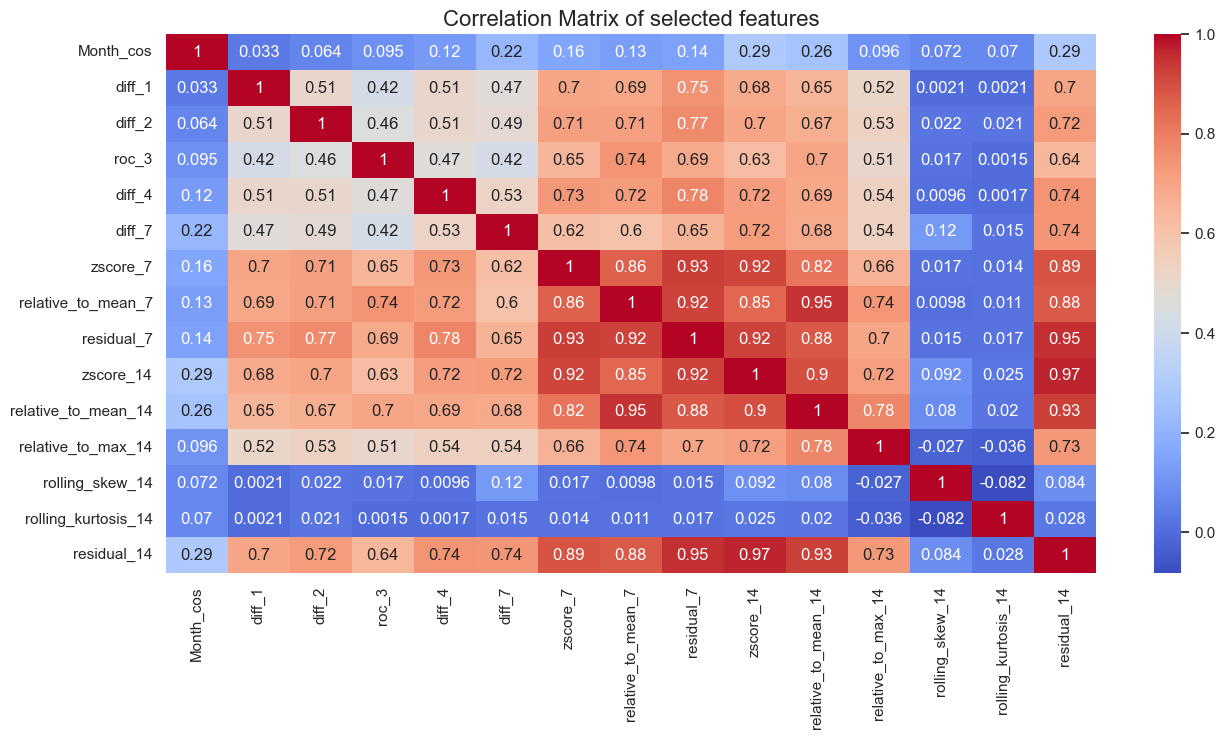

In [40]:
plt.figure(figsize=(15, 7))
plt.title('Correlation Matrix of selected features', fontsize=16)
sns.heatmap(X_train[columns_to_standarize].corr(), cmap='coolwarm', annot=True)

Well, this was kind of expected. We extract same features at different rolling windows, which can lead to features being strongly correlated with each other. Multicollinearity can be a big issue for linear/distance-based models like logistic regression for model interpretation as we might want to see coefficients to check which model is impacting the model by what factor. When you have a bunch of features strongly correlated with the feature and target, it becomes difficult to understand the impact of individual features on model's descision making. Tree based models are generally pretty robust to multicollinearity as they look at one feature at once and not all at once. They also don't make any assumptions about the data. Perhaps the best thing about Random Forest is only selecting random subset of rows and columns, which ensures that every tree is unique.

# Model Training, Optimization, and Testing

In this step, we train three classifiers: Random Forest, Decision Tree, and Logistic Regression. We use different metrics to evaluate model performance from different angles.

## 1. Random Forest

In [41]:
%%time

# this is our hyperparameter space for random forest
param_space = {
    'model__n_estimators': [100, 300, 500, 1000],
    'model__max_depth': [4, 5, 6, 7, 8],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True],
    'model__n_jobs': [-1],
    'model__max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    'model__max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'model__random_state': [42],
}

random_forest_pipeline = Pipeline([
    ('model',  RandomForestClassifier(n_jobs=-1, random_state=42))
])

random_search, best_model = optimize_model(random_forest_pipeline, X_train, y_train, param_space, 25)

CPU times: total: 2.81 s
Wall time: 1min 19s


In [42]:
print(f'Validation Best Score: {random_search.best_score_:.2%}')

Validation Best Score: 84.91%


In [43]:
random_search.best_estimator_["model"]

RandomForestClassifier(max_depth=8, max_features=0.9, max_samples=1.0,
                       min_samples_leaf=2, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [44]:
def perform_deep_test_analysis(model_object: Pipeline, model_name: str) -> None:
    """"
    This function takes in a model object and model name, and performs a deep analysis on the model's performance on the test set.
    It prints classification report, confusion matrix, ROC AUC score and plots the ROC curve.
    """
    test_preds = model_object.predict(X_test)
    test_preds_proba = model_object.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, test_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")
    print("FOR TESTING SET: ")
    print(classification_report(y_test, test_preds))
    print("\n")

    print(f"ROC AUC Score: {roc_auc_score(y_test, test_preds_proba):.2%}")
    print("\n")

    fpr, tpr, _ = roc_curve(y_test, test_preds_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

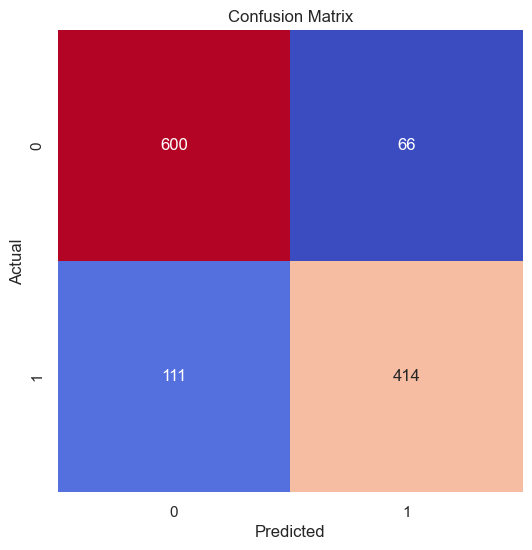



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       666
           1       0.86      0.79      0.82       525

    accuracy                           0.85      1191
   macro avg       0.85      0.84      0.85      1191
weighted avg       0.85      0.85      0.85      1191



ROC AUC Score: 91.53%




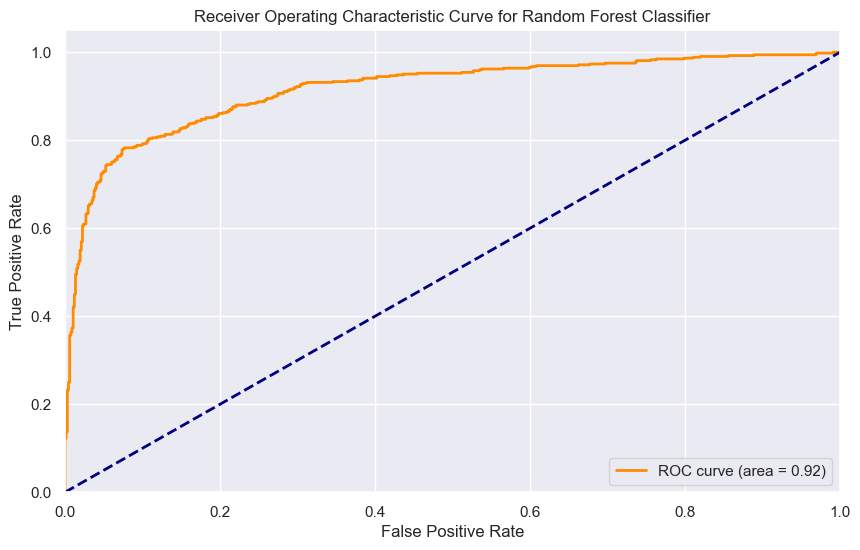

In [45]:
perform_deep_test_analysis(best_model, "Random Forest Classifier")

From the above confusion matrix, we can see that, model was able to correctly classify 414 positives cases our of 525 positive cases, with recall being around 78%. Similarly, there are lots of false positives and false negatives. The model wrongly classified 111 anomaly cases as non-anomaly. Simiarly, for 66 non-anomaly cases, the model predicted them to be anomalous.

Our model has precision, recall and f1 scores of 0.86, 0.79 and 0.82 respectively for class 1. It means that, out of all positive predictions made by the model, 86% of them are actually positive (True Positives), whereas 14% of them are false alarms (False Negatives). For recall, our model was able to detect 79% of all positive cases in the dataset and missed 21% of the positives (or anamolies). Finally, our F1 score is 0.82 indicating model has generally good performance on the anomaly class. It's not perfect but there is a room for improvement.

Also, our AUC (area under the curve of ROC Curve) score is almost 92%, which indicates very good discriminative power of the model. Model is pretty good in distinguishing data from anomaly and non-anomaly.

What it actually means is that, if we choose a random anomaly row and random non-anomaly row, the chance that the model will assign higher probability to the anomaly row is 92%. Essentially, the model is correctly ranking anomaly rows higher than non-anomaly rows 92% of the time. 

In [46]:
random_search.best_estimator_["model"]

RandomForestClassifier(max_depth=8, max_features=0.9, max_samples=1.0,
                       min_samples_leaf=2, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [47]:
feature_importances = pd.DataFrame({'feature': X_test.columns, 'importance': random_search.best_estimator_.named_steps['model'].feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [48]:
feature_importances

,feature,importance
8,residual_7,0.267237
9,zscore_14,0.252406
14,residual_14,0.229002
0,Month_cos,0.081750
6,zscore_7,0.023666
12,rolling_skew_14,0.019867
5,diff_7,0.019500
13,rolling_kurtosis_14,0.016885
4,diff_4,0.015005
2,diff_2,0.014817


In [49]:
feature_importances['importance'].sum()

1.0

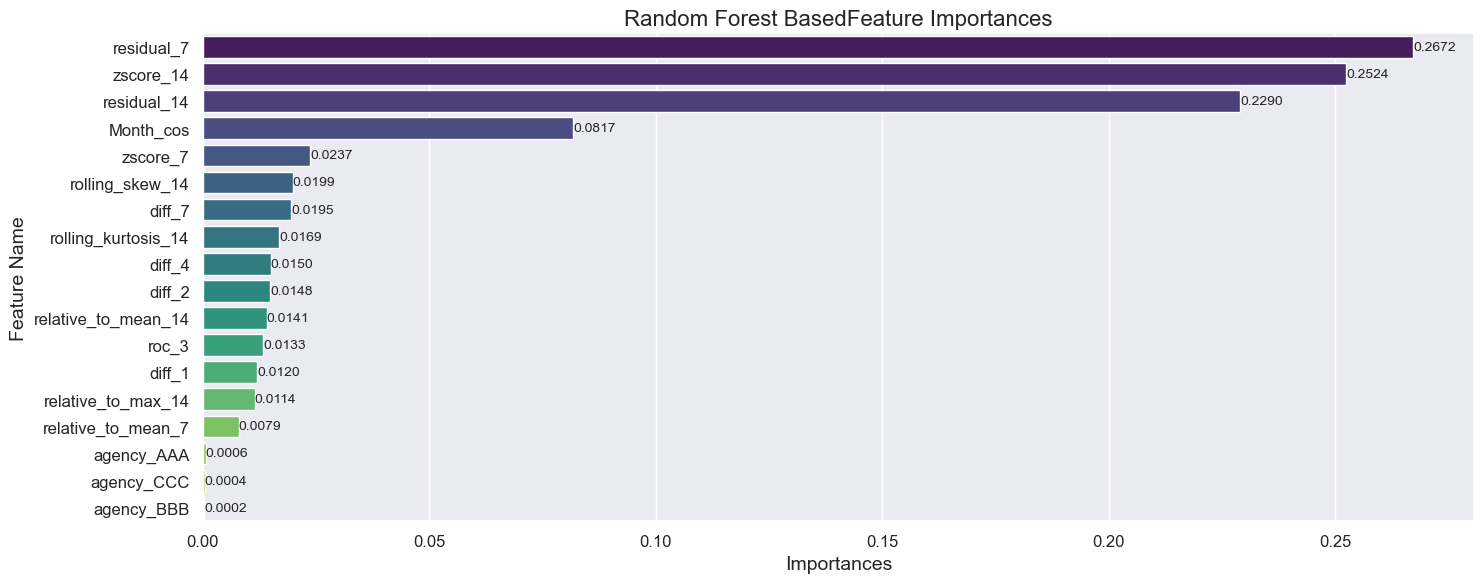

In [50]:
plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importances, x='importance', y='feature', palette='viridis')
plt.title('Random Forest BasedFeature Importances', fontsize=16)
plt.xlabel('Importances', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

Well, the random forest model feature importance plot shows that residual_7, z_score_14 and residual_14 features are the most important features followed by cos of month. Interesting. Agency one hot encoded features did not seem to help the model. It could be that the model might have captured underlying relationship in the agency itself.

In [51]:
test_preds = best_model.predict(X_test)
temp = df_transformed[["date", "value", "agency", "anomaly"]].copy()
temp = temp[temp.date > "2023-12-31"].copy()
temp["preds"] = test_preds
temp["is_predicted_correctly"] = np.where(temp["preds"] == temp["anomaly"], 1, 0) 

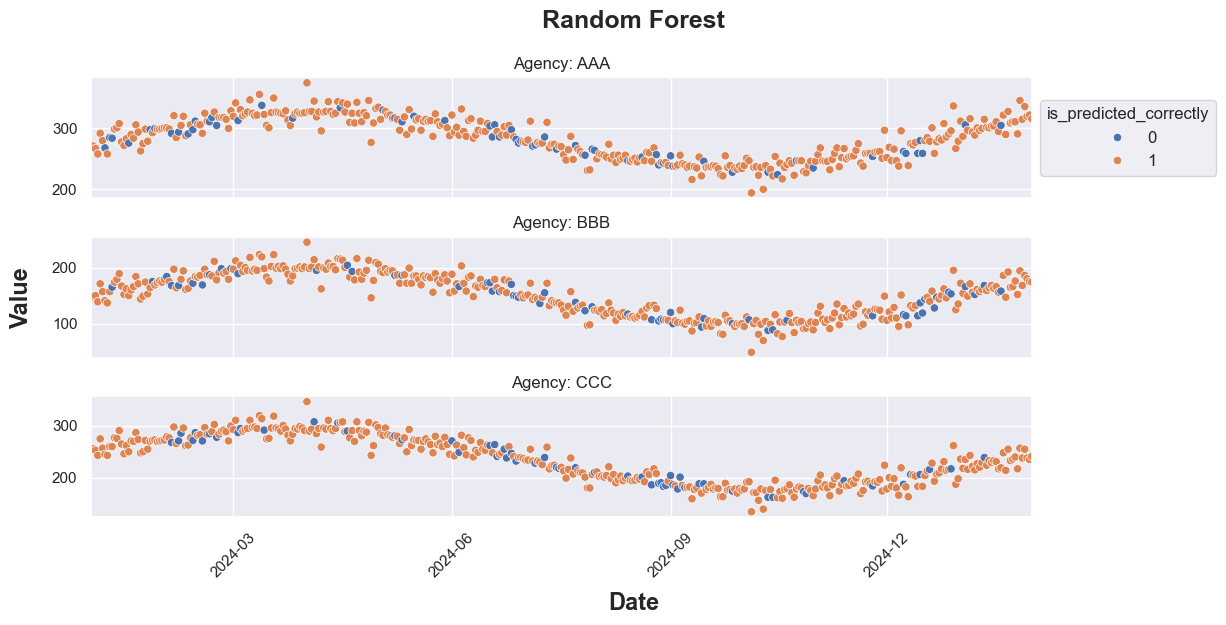

In [52]:
'''
This figure shows the predicted values for each agency. The blue dots are the predicted anomalies, while the orange dots are the predicted non-anomalies.
'''
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

agencies = ['AAA', 'BBB', 'CCC']
for i, agency in enumerate(agencies):
    sns.scatterplot(ax=axes[i], data=temp[temp['agency'] == agency], x='date', y='value', hue='is_predicted_correctly')
    axes[i].set_title(f'Agency: {agency}')
    axes[i].legend(title='is_predicted_correcly')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # we only need one legend
    if i != 0:
        axes[i].get_legend().remove()

    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].set_xlim(pd.Timestamp('2024-01-01'), pd.Timestamp('2025-01-31'))
    axes[i].tick_params(axis='x', rotation=45)

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=17, fontweight='bold')
fig.text(-0.02, 0.5, 'Value', va='center', rotation='vertical', fontsize=17, fontweight='bold')

axes[0].legend(title='is_predicted_correctly', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
fig.suptitle('Random Forest', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Higher Accuracy visible above, showing models validity 

## 2. Decision Tree

In [53]:
%%time

# hyperparameter Space for DecisionTree Classifier
param_space = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],  # Splitting criteria
    'model__max_depth': [4, 5, 6, 7],
    'model__min_samples_split': [2, 5, 10, 15, 20],  
    'model__min_samples_leaf': [1, 2, 4, 6, 8, 10],  
    'model__random_state': [42], 
    'model__class_weight':[None, 'balanced']
}


# Decision Tree pipeline
Decision_tree_pipeline = Pipeline([
    ('model',  DecisionTreeClassifier(random_state=42))
])

random_search, best_model = optimize_model(Decision_tree_pipeline, X_train, y_train, param_space, 25)

CPU times: total: 172 ms
Wall time: 590 ms


In [54]:
print(f"Training F1 Score: {random_search.best_estimator_.score(X_train, y_train):.2%}") 
print(f"Mean Validation F1 Score: {random_search.best_score_:.2%}") 

Training F1 Score: 88.73%
Mean Validation F1 Score: 82.34%


In [55]:
random_search.best_estimator_["model"]

DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=7, min_samples_leaf=6, min_samples_split=5,
                       random_state=42)

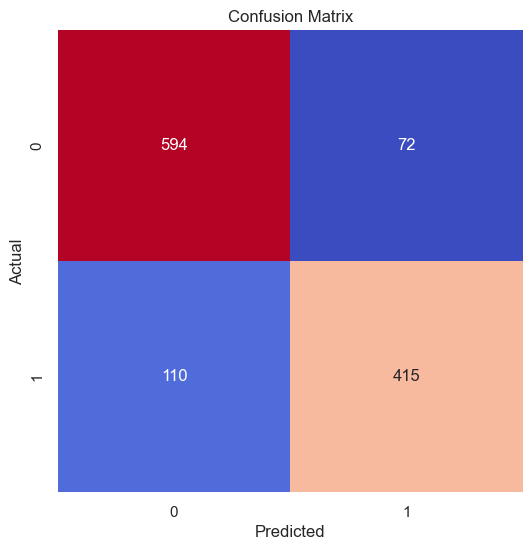



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       666
           1       0.85      0.79      0.82       525

    accuracy                           0.85      1191
   macro avg       0.85      0.84      0.84      1191
weighted avg       0.85      0.85      0.85      1191



ROC AUC Score: 86.49%




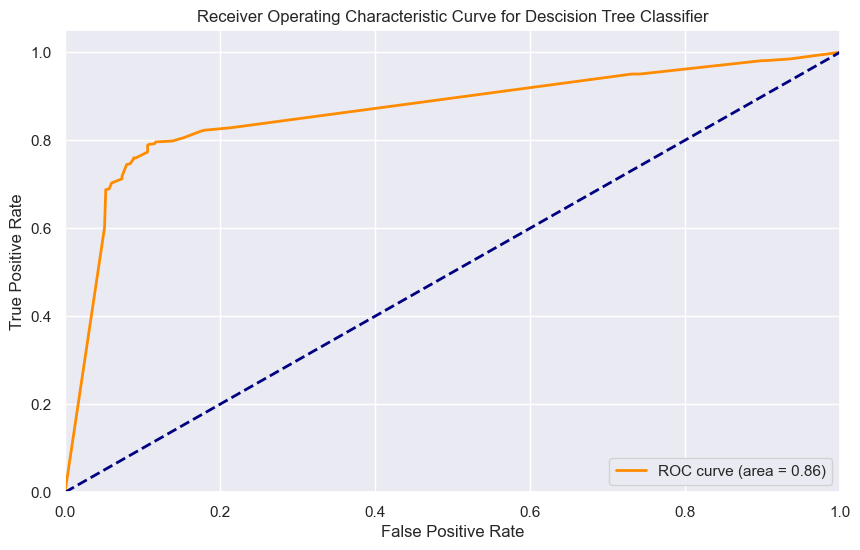

In [56]:
perform_deep_test_analysis(random_search.best_estimator_, "Descision Tree Classifier")

In [57]:
decision_tree_model = random_search.best_estimator_["model"]
decision_tree_model

DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=7, min_samples_leaf=6, min_samples_split=5,
                       random_state=42)

In [58]:
feature_importances = pd.DataFrame({'feature': X_test.columns, 'importance': decision_tree_model.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

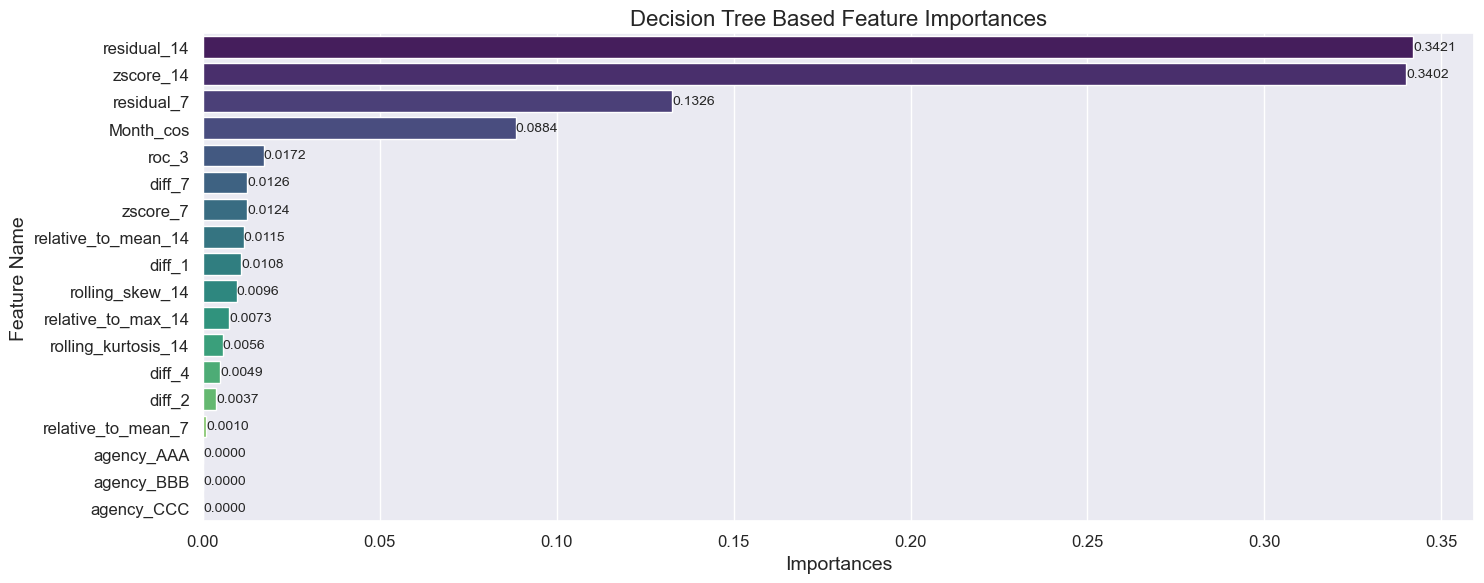

In [59]:
plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importances, x='importance', y='feature', palette='viridis')
plt.title('Decision Tree Based Feature Importances', fontsize=16)
plt.xlabel('Importances', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

From the above confusion matrix, we can see that, model was able to correctly classify 415 positives cases our of 525 positive cases, with recall being around 78%. Similarly, there are lots of false positives and false negatives. The model wrongly classified 110 anomaly cases as non-anomaly. Simiarly, for 72 non-anomaly cases, the model predicted them to be anomalous.

Our model has precision, recall and f1 scores of 0.85, 0.79 and 0.82 respectively for class 1. It means that, out of all positive predictions made by the model, 85% of them are actually positive (True Positives), whereas 15% of them are false alarms (False Negatives). For recall, our model was able to detect 79% of all positive cases in the dataset and missed 21% of the positives (or anamolies). Finally, our F1 score is 0.82 indicating model has generally good performance on the anomaly class. It's not perfect but there is a room for improvement.

Also, our AUC (area under the curve of ROC Curve) score is almost 85%, which indicates very good discriminative power of the model. Model is pretty good in distinguishing data from anomaly and non-anomaly.

What it actually means is that, if we choose a random anomaly row and random non-anomaly row, the chance that the model will assign higher probability to the anomaly row is 85%. Essentially, the model is correctly ranking anomaly rows higher than non-anomaly rows 85% of the time. 

<B> The performance of Decision Tree Classifier is pretty close to the Random Forest Classifier.

## 3. Logistic Regression

In [60]:
%%time

# hyperparameter space for logistic regression
param_space = {
    'model__penalty': ['l1', 'l2', None, "elasticnet"], 
    'model__C': [0.01, 0.1, 1, 10, 100], 
    'model__max_iter': [100, 200, 500, 1000, 10000],  
    'model__class_weight': [None, 'balanced'],  
    "model__fit_intercept": [True, False],
    'model__random_state': [42],  
}

# column transformer for scaling the features
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), columns_to_standarize)],
    remainder='passthrough'
)

# logistic regression pipeline
logistic_regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  LogisticRegression())
])

# optimizing the logistic regression model
random_search, best_model = optimize_model(logistic_regression_pipeline, X_train, y_train, param_space, 25)

CPU times: total: 172 ms
Wall time: 460 ms


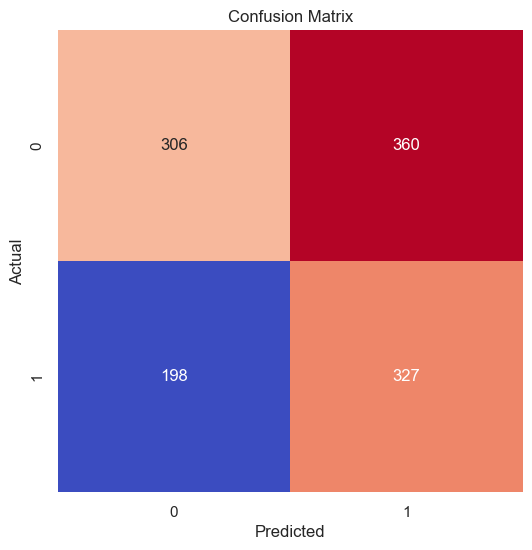



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.61      0.46      0.52       666
           1       0.48      0.62      0.54       525

    accuracy                           0.53      1191
   macro avg       0.54      0.54      0.53      1191
weighted avg       0.55      0.53      0.53      1191



ROC AUC Score: 55.98%




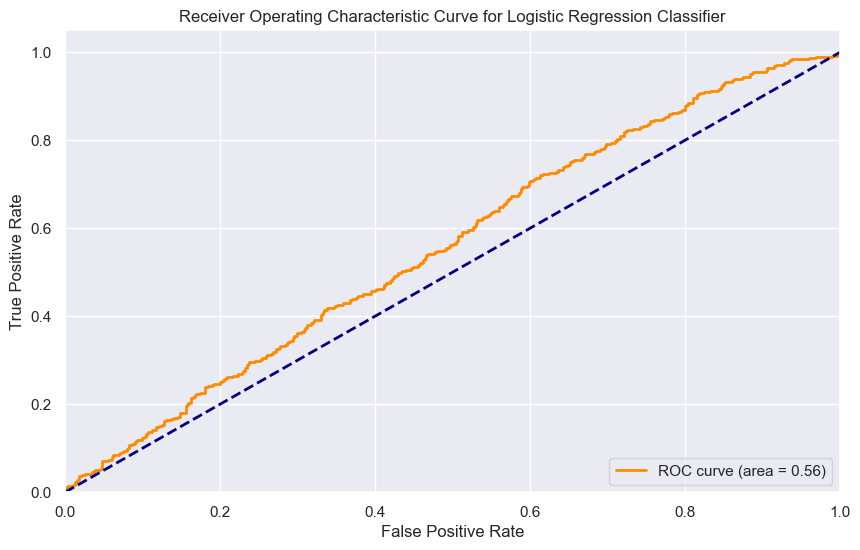

In [61]:
perform_deep_test_analysis(best_model, "Logistic Regression Classifier")

Well, the Logistic Regression model is significantly underperforming. It is severely underfitting. The confusion matrix is horrible. It has 360 false positives and 198 false negatives. The accuracy us barely 53%. The ROC curve shows that this model has very poor discriminatory ability to distinguish between anomaly and non-anomaly rows.

Let's look at the model's coefficients regardless.

In [62]:
logistic_reg_model = random_search.best_estimator_.named_steps['model']
logistic_reg_model

LogisticRegression(C=100, class_weight='balanced', fit_intercept=False,
                   max_iter=200, random_state=42)

In [63]:
logistic_reg_model.intercept_

array([0.])

In [64]:
feature_importances = pd.DataFrame({'feature': X_test.columns, 'slope': logistic_reg_model.coef_[0]})

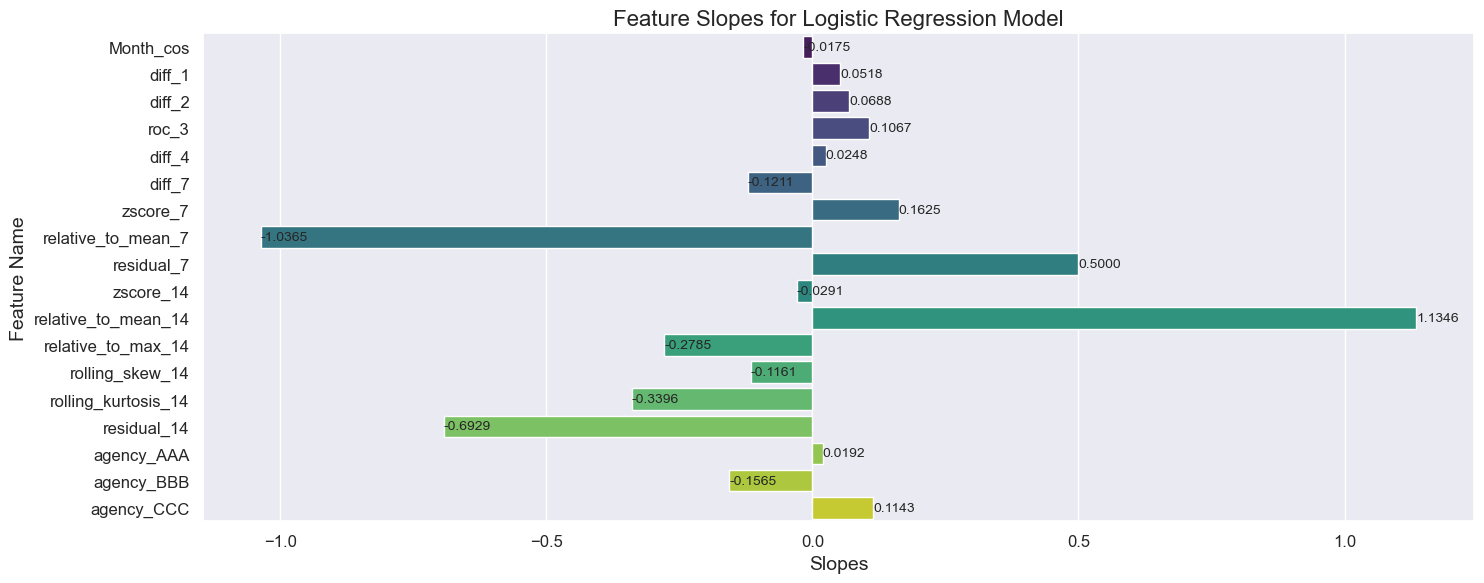

In [65]:
plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importances, x='slope', y='feature', palette='viridis')
plt.title('Feature Slopes for Logistic Regression Model', fontsize=16)
plt.xlabel('Slopes', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(feature_importances['slope']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

Well, Some features are negatively impacting the model whereas other are positively impacting the model. It might not make sense to look at these coefficients as there is significant multicollinearity in the dataset, which will likely lead to unstable coefficients. If you look at feature relative_to_mean7 and relative_to_mean14 they have two largest slopes in terms of magnitude but they are in opposite direction, which does not make any sense.

# Summary

Random Forest Classifier is the most accurate model among the three we experimented. Logistic Regression severely underfits and has no ability to distinguish between anomaly and non-anomaly cases. The Random Forest model has highest F1 score in the test set, which is our choosen metric.

Now comes the important part, Interpretation:

1. If we focus on precision, we would want to reduce false positives. Or, false alarms for anomalies. If our model says a row is anomalous, it better be right. (No false positives or Type 1 errors).
2. If we focus on recall, we would want the model to capture all of the anomaly cases in the dataset. (essentially, what fraction of the true anamolies did the model detect).
    We would want to reduce False Negatives (Type 2 error) for reall
3. F1 score is harmonic mean of precision and recall. If we focus on F1 score, we would want to balance both FP and FN.

| Scenario                                             | Best Metric  to Choose?      | Reasoning                                                                                      |
|------------------------------------------------------|--------------------|-------------------------------------------------------------------------------------------|
| Anomalies  are critically important. Even missing one is risky (e.g., fraud cases, safety, nuclear reactor work) | Recall             | Missing one anomaly could have disastrous consequences. It’s critical to capture all anomalies. Imagine a nuclear reactor failure due to missing an anomaly.|
| You don't want false positives. If your model says this is an anomaly, IT BETTER BE RIGHT (e.g., for fraud detection, unnecessary investigations) | Precision          | False positives are costly. For example, manual inspections for fraudulent activity. If you audit someone based on a false positive prediction, they COULD SUE YOU !!. If Netflix recommends you a bunch of non-relevant movies, you will stop watching netflix. |
| This is a Balanced approach.                                    | F1                 | A trade-off between recall and precision, balancing the need for capturing anomalies and minimizing false positives. |


<b> In our dataset, if there was severe class imbalance, and if this dataset were from a domain where missing even one anomaly is hazardous, we would go with recall.
If this data were from a domain where we want to reduce false positives, and if model said YES, then it better be right. In this case, we would go for precision.

Given that we don't really have much class-imbalance in our dataset, we decided to go with a balanced approach (F1-Score). That's why use used this metric on model-tuning.



<b> To summarize, we can use our optimized Random Forest model to detect anomalies on our dataset with high accuracy.

# Conclusion: Given the data we have and using a Random Forest Classifier, we can accurately predict anomalies at a rate of 85%


# Future Work
* # Create greater windows for looking over (1 to 2 years) without data loss
* # Create feature that combines the year over year differences with the cosine function